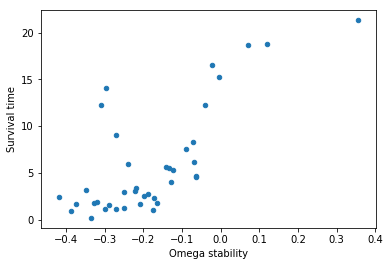

In [1]:
# Загрузим данные с помощью модуля Pandas в объект DataFrame
import pandas as pd
omega_stability = pd.read_csv("../input/omega-stability-data/omega_stability.csv")

# Проведем первичную обработку данных
omega_stability = omega_stability.T
omega_stability = omega_stability.drop(index = "Name")
omega_stability.columns = ["Omega stability", "Survival time"]

# Преобразуем значения ячеек в числовые
omega_stability["Omega stability"] = omega_stability["Omega stability"].astype(float)
omega_stability["Survival time"] = omega_stability["Survival time"].astype(float)

x = omega_stability["Omega stability"].values
y = omega_stability["Survival time"].values

# Проведем визуализацию
omega_stability.plot(kind="scatter", x="Omega stability", y="Survival time")

In [2]:
# Построение LTS-оценки
def c_step(x, y, x0, model_func, tolerance, max_iter, h0):
    import math
    import random
    import numpy as np
    from scipy.optimize import least_squares
    from scipy.optimize import curve_fit 
    residual_func = lambda a, x, y: model_func(x, a) - y
    i = 1
    H1 = random.sample(range(len(x)), h0)
    Q1 = 9999999
    prev = 0
    error = abs(Q1-prev)
    theta = []
    # Получение x0
    x0 = least_squares(residual_func, x0, loss="linear", args=(x, y)).x
    while error > tolerance and i < max_iter:
        theta = least_squares(residual_func, x0, loss="linear", args=(x[H1], y[H1])).x
        est = model_func(x, theta)
        e = y - est
        prev = Q1
        Q1 = sum(e**2)
        error = abs(Q1 - prev)
        pi = np.argsort(np.abs(e))
        H1 = pi[:h0]
        i += 1
        #print(error)
    return theta

In [3]:
def loo_cross_validation_lts(x, y, model_func, h0):
    import math
    import numpy as np
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import LeaveOneOut
    loo = LeaveOneOut()
    predicts = []    
    for train, test in loo.split(x):
        x_train = x[train]
        y_train = y[train]
        x_test = x[test]
        y_test = y[test]
        a = c_step(x, y, [0, 0, 0, 0], model_func, 1e-7, 500, h0)
        predict = model_func(x_test, a)
        predicts.append(predict)
    rmse = math.sqrt(mean_squared_error(y, predicts))
    return rmse, a

In [4]:
def cube_func(x, a):
    return a[0] + a[1] * x + a[2] * x**2 + a[3] * x**3
def cube_func_ols(x, a0, a1, a2, a3):
    return a0 + a1 * x + a2 * x**2 + a3 * x**3

[  13.28110565   59.09069477  -15.25143816 -242.83236977]
h0 = 30


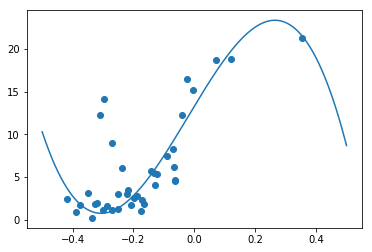

In [5]:
a = c_step(x, y, [0, 0, 0, 0], cube_func, 1e-7, 100, 30)
print(a)
print("h0 =",30)

import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x, y)
x_plot = np.linspace(-0.5, 0.5, num=1000)
y_plot = cube_func(x_plot, a)
ax.plot(x_plot, y_plot)

In [6]:
d = {}
cv_m, a_m = 300, []
h0 = 0
for i in range(22, 40):
    cv, a = loo_cross_validation_lts(x, y, cube_func, i)
    d[i] = a
    if cv < cv_m:
        cv_m = cv
        a_m = a
        h0 = i
    print("i " + str(i))
    print(cv)
print("min cv ", cv_m)
print("h0", h0)
print(a_m)

i 22
3.8460391994490237
i 23
4.298060175766834
i 24
11.880871650573704
i 25
7.239075278482052
i 26
3.5289801439854447
i 27
3.572722546511443
i 28
7.580837230376349
i 29
3.6065394789944927
i 30
3.5489852049722446
i 31
3.5959921932251917
i 32
3.5937116277433594
i 33
3.5543838821605567
i 34
3.6641689855180384
i 35
3.626500401017847
i 36
3.626500148501856
i 37
3.547293330888362
i 38
3.4724148954001173
i 39
3.444861579883074
min cv  3.444861579883074
h0 39
[  12.09694901   49.76389472    4.50501477 -179.41888608]


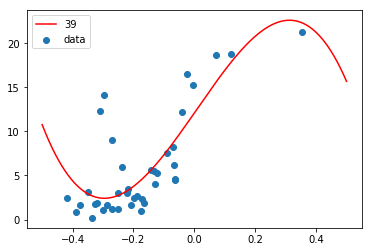

In [7]:
fig, ax = plt.subplots()
ax.scatter(x, y)
x_plot = np.linspace(-0.5, 0.5, num=1000)
y_plot = a_m[0] + a_m[1]*x_plot + a_m[2]*x_plot**2 + a_m[3]*x_plot**3
ax.plot(x_plot, y_plot, c="r")
ax.legend((h0, "data"))

[  12.09694892   49.76389417    4.50501634 -179.41887845]


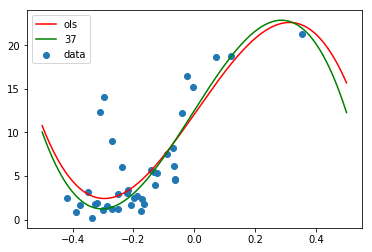

In [8]:
fig, ax = plt.subplots()
ax.scatter(x, y)
x_plot = np.linspace(-0.5, 0.5, num=1000)
# ols
from scipy.optimize import curve_fit
a, _ = curve_fit(cube_func_ols, x, y)
print(a)
y_plot = cube_func(x_plot, a)
ax.plot(x_plot, y_plot, c="r")
#ax.legend(("ols", "data"))

#37
h0 = 37
y_plot = cube_func(x_plot, d[h0])
ax.plot(x_plot, y_plot, c="g")
ax.legend(("ols", h0, "data"))

In [9]:
# M-estimators

In [10]:
residual_func = lambda a, x, y: cube_func(x, a) - y
theta = least_squares(residual_func, [13.2172348, 59.92121269, -14.74252034, -249.17161382], loss="huber", args=(x, y))
a_m = theta.x
fig, ax = plt.subplots()
ax.scatter(x, y)
x_plot = np.linspace(-0.5, 0.5, num=1000)
y_plot = a_m[0] + a_m[1]*x_plot + a_m[2]*x_plot**2 + a_m[3]*x_plot**3
ax.plot(x_plot, y_plot)

NameError: name 'least_squares' is not defined

In [11]:
def loo_cross_validation_robust(x, y, model_func):
    import math
    from scipy.optimize import curve_fit 
    import numpy as np
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import LeaveOneOut
    residual_func = lambda a, x, y: model_func(x, a) - y
    loo = LeaveOneOut()
    predicts = []    
    for train, test in loo.split(x):
        x_train = x[train]
        y_train = y[train]
        x_test = x[test]
        y_test = y[test]
        robust = least_squares(residual_func, [13.2172348, 59.92121269, -14.74252034, -249.17161382], f_scale = 0.1, loss='arctan', args=(x_train, y_train))
        param = robust.x
        predict = model_func(x_test, param)
        predicts.append(predict)
    rmse = math.sqrt(mean_squared_error(y, predicts))
    return rmse

In [12]:
print(loo_cross_validation_robust(x, y, cube_func))

NameError: name 'least_squares' is not defined